In [2]:
# python ######################################################################
import sys
import os
import datetime

# basics ######################################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# widgets #####################################################################
import ipywidgets as widgets
from ipywidgets import interact

# process mining ##############################################################
import pm4py

# object.log
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.importer.xes import importer as xes_importer

# object.conversion
from pm4py.objects.conversion.dfg import converter as dfg_converter
from pm4py.objects.conversion.process_tree import converter as pt_converter

# algo.discovery
from pm4py.algo.discovery.alpha import variants
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.correlation_mining import algorithm as correlation_miner
from pm4py.visualization.dfg import visualizer as dfg_visualizer

# algo.conformance
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay

# vizualization
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# util
from pm4py.util import vis_utils

# Define directories
from src import SRC_DIR

import warnings
warnings.filterwarnings("ignore")

In [3]:
import jdatetime

In [4]:
def _(text):
    return get_display(
        arabic_reshaper.reshape(
            u'%s' % str(text)
      )
   )

In [5]:
def activity_duration(
    event_log: pd.DataFrame,
    case_var: str,
    event_var: str,
    timestamp_var: str,
    duration_type: str ='h'
) -> pd.DataFrame:
    
    """
    Returns a dataframe with activity durations (i.e. 'arc' performance decorators).
    By default duration_type is set to hours (h).
    Use 's' for seconds, 'D' for days and 'W' for weeks.
    """
    
    event_log = event_log.rename(columns = {event_var: 'event_from',
                                            timestamp_var: 'time_from'})

    dfs_list = []
    groups = event_log.groupby(case_var)
    for name, group in groups:
        arc = group.sort_values('time_from')
        arc['event_to'] = arc['event_from'].shift(-1)
        arc['time_to'] = arc['time_from'].shift(-1)
        arc.dropna(inplace = True)
        duration_var = f'duration ({duration_type})'
        arc[duration_var] = (arc['time_to'] - arc['time_from']) / np.timedelta64(1, duration_type)
        
        dfs_list.append(arc[[case_var, 'event_from', 'event_to', 'time_from', 'time_to', duration_var]])

    return pd.concat(dfs_list).set_index(case_var)

In [6]:
event_log = pd.read_excel(SRC_DIR / 'Dataset' / 'Fall Sales Order.xlsx')


In [7]:
event_log_str=event_log['زمان انجام'].str.replace('/', ' ').str.replace(':', ' ').str.split()
event_log_int = [[int(val) for val in row] for row in event_log_str]
gregorian_date=[jdatetime.datetime(event_log_int[item][0],event_log_int[item][1],event_log_int[item][2],event_log_int[item][3],event_log_int[item][4],event_log_int[item][5]).togregorian() for item in range(99973)]
gregorian_date=pd.to_datetime(gregorian_date)
event_log['timestamp']=gregorian_date

In [8]:
event_log.head()

,شماره پرونده,فعاليت,زمان انجام,نوع سند,ناحيه فروش,شرح ناحيه فروش,مشتري,گروه مشتري,شرح گروه مشتري,نام کاربري,ويزيتور,نام ويزيتور,وضعیت مرجوعی,سند حمل,کد موزع,نام موزع,نوع پرداخت,شرح نوع پرداخت,timestamp
0,100989739,سفارش فروش,1400/07/01 08:11:44,ZO20,202012,منطقه10,14021788,1,خرده فروشي,VARANEGAR,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-23 08:11:44
1,100989739,تاييد سرپرست,1400/07/01 11:38:51,ZO20,202012,منطقه10,14021788,1,خرده فروشي,A_KESHAVARZ,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-23 11:38:51
2,100989739,دستور تحويل,1400/07/01 12:48:12,ZLF3,202012,منطقه10,14021788,1,خرده فروشي,F_ASHNAGAR,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-23 12:48:12
3,100989739,سند حمل,1400/07/01 15:15:40,ZP01,202012,منطقه10,14021788,1,خرده فروشي,H_FALAH,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-23 15:15:40
4,100989739,دريافت تور,1400/07/03 06:59:57,ZP01,202012,منطقه10,14021788,1,خرده فروشي,H_FALAH,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-25 06:59:57


In [9]:
event_log = event_log.rename(columns = {'شماره پرونده': 'case_id',
                                         'فعاليت':'activity',
                                         'گروه مشتري':'customer group',
                                         'وضعیت مرجوعی':'returned status',
                                         'نوع سند' : 'type of document',
                                          
                                         })


In [10]:
event_log['case_id']=event_log['case_id'].astype("string")

In [11]:
event_log.dtypes

case_id             string[python]
activity                    object
زمان انجام                  object
type of document            object
ناحيه فروش                   int64
شرح ناحيه فروش              object
مشتري                        int64
customer group               int64
شرح گروه مشتري              object
نام کاربري                  object
ويزيتور                     object
نام ويزيتور                 object
returned status             object
سند حمل                      int64
کد موزع                     object
نام موزع                    object
نوع پرداخت                  object
شرح نوع پرداخت              object
timestamp           datetime64[ns]
dtype: object

In [12]:
pm4py.format_dataframe(
    event_log,
    case_id = 'case_id',
    activity_key = 'activity',
    timestamp_key = 'timestamp', 
    timest_format = '%Y-%m-%d %H:%M:%S'
)

,case_id,activity,زمان انجام,type of document,ناحيه فروش,شرح ناحيه فروش,مشتري,customer group,شرح گروه مشتري,نام کاربري,...,کد موزع,نام موزع,نوع پرداخت,شرح نوع پرداخت,timestamp,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
0,100989739,سفارش فروش,1400/07/01 08:11:44,ZO20,202012,منطقه10,14021788,1,خرده فروشي,VARANEGAR,...,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-23 08:11:44+00:00,100989739,سفارش فروش,2021-09-23 08:11:44+00:00,0,0
1,100989739,تاييد سرپرست,1400/07/01 11:38:51,ZO20,202012,منطقه10,14021788,1,خرده فروشي,A_KESHAVARZ,...,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-23 11:38:51+00:00,100989739,تاييد سرپرست,2021-09-23 11:38:51+00:00,1,0
2,100989739,دستور تحويل,1400/07/01 12:48:12,ZLF3,202012,منطقه10,14021788,1,خرده فروشي,F_ASHNAGAR,...,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-23 12:48:12+00:00,100989739,دستور تحويل,2021-09-23 12:48:12+00:00,2,0
3,100989739,سند حمل,1400/07/01 15:15:40,ZP01,202012,منطقه10,14021788,1,خرده فروشي,H_FALAH,...,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-23 15:15:40+00:00,100989739,سند حمل,2021-09-23 15:15:40+00:00,3,0
4,100989739,دريافت تور,1400/07/03 06:59:57,ZP01,202012,منطقه10,14021788,1,خرده فروشي,H_FALAH,...,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-25 06:59:57+00:00,100989739,دريافت تور,2021-09-25 06:59:57+00:00,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99968,101189084,سند حمل,1400/09/30 16:21:59,ZP01,202005,منطقه2,14020440,1,خرده فروشي,H_FALAH,...,E5700198,احمد امین,PT01,نقد / حواله / پوز - تسويه کامل آني,2021-12-21 16:21:59+00:00,101189084,سند حمل,2021-12-21 16:21:59+00:00,99968,12602
99969,101189084,دريافت تور,1400/10/01 06:54:30,ZP01,202005,منطقه2,14020440,1,خرده فروشي,H_FALAH,...,E5700198,احمد امین,PT01,نقد / حواله / پوز - تسويه کامل آني,2021-12-22 06:54:30+00:00,101189084,دريافت تور,2021-12-22 06:54:30+00:00,99969,12602
99970,101189084,ارسال تور,1400/10/01 12:20:50,ZP01,202005,منطقه2,14020440,1,خرده فروشي,H_FALAH,...,E5700198,احمد امین,PT01,نقد / حواله / پوز - تسويه کامل آني,2021-12-22 12:20:50+00:00,101189084,ارسال تور,2021-12-22 12:20:50+00:00,99970,12602
99971,101189084,سند انبار,1400/10/01 13:43:54,WL,202005,منطقه2,14020440,1,خرده فروشي,R_MIRAZIMI,...,E5700198,احمد امین,PT01,نقد / حواله / پوز - تسويه کامل آني,2021-12-22 13:43:54+00:00,101189084,سند انبار,2021-12-22 13:43:54+00:00,99971,12602


<div style="direction:rtl;line-height:300%;">
	<font face="XB Zar" size=4 color=blue>
		<div align=right>
			<font face="B zar" size=5>
				<p></p>
				<p></p>
              همانگونه که در زیر دیده می‌شود تعداد هر فعالیت 12603 است اما تعداد فعالیت سند انبار 12607 است که این نشان می‌شود در این فعالیت دوباره کاری صورت گرفته است. 

In [14]:
from pm4py.algo.filtering.log.attributes import attributes_filter
activities = attributes_filter.get_attribute_values(event_log, "concept:name")
activities

{'سفارش فروش': 12603,
 'تاييد سرپرست': 12603,
 'دستور تحويل': 12603,
 'سند حمل': 12603,
 'دريافت تور': 12603,
 'ارسال تور': 12603,
 'سند انبار': 12607,
 'فاکتور فروش': 11748}

<div style="direction:rtl;line-height:300%;">
	<font face="XB Nazanin" size=4 color=blue>
		<div align=right>
			<font face="B Nazanin" size=5>
				<p></p>
				<p></p>
در دیتافریم زیر نشان داده شده است از فعالیت سند انبار به فعالیت سند انبار رفته است که نشان دهنده دوباره کاری است.
<br>همچنین از فعالیت فاکتور فروش به فاکتور فروش نیز وجود دارد که در این فعالیت نیز دوباره کاری انجام شده است. 


In [18]:
ad_df = activity_duration(event_log, 'case_id', 'activity', 'timestamp')

ad_df = ad_df.groupby(by = ['event_from', 'event_to']).agg(
    mean_duration = ('duration (h)', 'mean'),
    total_duration = ('duration (h)', 'sum'),
    std_duration = ('duration (h)', 'std'),
    count = ('event_from', 'count')
).reset_index()

ad_df

,event_from,event_to,mean_duration,total_duration,std_duration,count
0,ارسال تور,سند انبار,0.776077,9780.896389,0.630169,12603
1,تاييد سرپرست,دستور تحويل,1.171383,14762.936389,3.642978,12603
2,دريافت تور,ارسال تور,5.796661,73055.320278,4.722683,12603
3,دستور تحويل,دريافت تور,2.010444,10.052222,1.495084,5
4,دستور تحويل,سند حمل,2.752147,34671.554167,3.821181,12598
5,سفارش فروش,تاييد سرپرست,1.525684,19228.193889,3.052040,12603
6,سند انبار,سند انبار,1.996250,3.992500,0.071693,2
7,سند انبار,فاکتور فروش,0.319522,3753.103889,5.789051,11746
8,سند حمل,دريافت تور,23.510841,296189.579167,18.976553,12598
9,سند حمل,سفارش فروش,17.974056,89.870278,0.983692,5


<div style="direction:rtl;line-height:300%;">
	<font face="XB Nazanin" size=4 color=blue>
		<div align=right>
			<font face="B Nazanin" size=5>
				<p></p>
				<p></p>
دوباره کاری در دو شماره پرونده 101111064 و 101111075 برای فعالیت‌های سند انبار و فاکتور فروش صورت گرفته است.

In [35]:
filtered_log = pm4py.filter_activities_rework(event_log,'سند انبار',2)
pm4py.convert_to_dataframe(filtered_log)

,case_id,activity,زمان انجام,type of document,ناحيه فروش,شرح ناحيه فروش,مشتري,customer group,شرح گروه مشتري,نام کاربري,...,سند حمل,کد موزع,نام موزع,نوع پرداخت,شرح نوع پرداخت,timestamp,case:concept:name,concept:name,time:timestamp,start_timestamp
62791,101111064,سفارش فروش,1400/08/26 14:13:04,ZO20,202008,کمالشهر,15001412,8,مدير فروش سرد,M_AZIMI,...,156379,E5700238,علیرضا برازنده,PT02,رسيدي,2021-11-17 14:13:04+00:00,101111064,سفارش فروش,2021-11-17 14:13:04+00:00,2021-11-17 14:13:04+00:00
62792,101111064,تاييد سرپرست,1400/08/26 14:39:43,ZO20,202008,کمالشهر,15001412,8,مدير فروش سرد,M_AZIMI,...,156379,E5700238,علیرضا برازنده,PT02,رسيدي,2021-11-17 14:39:43+00:00,101111064,تاييد سرپرست,2021-11-17 14:39:43+00:00,2021-11-17 14:39:43+00:00
62793,101111064,دستور تحويل,1400/08/26 14:40:10,ZLF3,202008,کمالشهر,15001412,8,مدير فروش سرد,F_ASHNAGAR,...,156379,E5700238,علیرضا برازنده,PT02,رسيدي,2021-11-17 14:40:10+00:00,101111064,دستور تحويل,2021-11-17 14:40:10+00:00,2021-11-17 14:40:10+00:00
62794,101111064,سند حمل,1400/08/26 15:24:59,ZP01,202008,کمالشهر,15001412,8,مدير فروش سرد,H_FALAH,...,156379,E5700238,علیرضا برازنده,PT02,رسيدي,2021-11-17 15:24:59+00:00,101111064,سند حمل,2021-11-17 15:24:59+00:00,2021-11-17 15:24:59+00:00
62795,101111064,دريافت تور,1400/08/27 07:12:28,ZP01,202008,کمالشهر,15001412,8,مدير فروش سرد,H_FALAH,...,156379,E5700238,علیرضا برازنده,PT02,رسيدي,2021-11-18 07:12:28+00:00,101111064,دريافت تور,2021-11-18 07:12:28+00:00,2021-11-18 07:12:28+00:00
62796,101111064,ارسال تور,1400/08/27 13:08:55,ZP01,202008,کمالشهر,15001412,8,مدير فروش سرد,H_FALAH,...,156379,E5700238,علیرضا برازنده,PT02,رسيدي,2021-11-18 13:08:55+00:00,101111064,ارسال تور,2021-11-18 13:08:55+00:00,2021-11-18 13:08:55+00:00
62797,101111064,سند انبار,1400/08/30 14:26:24,WL,202008,کمالشهر,15001412,8,مدير فروش سرد,SH_GHOLAMI,...,156379,E5700238,علیرضا برازنده,PT02,رسيدي,2021-11-21 14:26:24+00:00,101111064,سند انبار,2021-11-21 14:26:24+00:00,2021-11-21 14:26:24+00:00
62798,101111064,سند انبار,1400/08/27 14:56:37,WL,202008,کمالشهر,15001412,8,مدير فروش سرد,R_MIRAZIMI,...,156379,E5700238,علیرضا برازنده,PT02,رسيدي,2021-11-18 14:56:37+00:00,101111064,سند انبار,2021-11-18 14:56:37+00:00,2021-11-18 14:56:37+00:00
62799,101111064,سند انبار,1400/08/30 16:29:13,WL,202008,کمالشهر,15001412,8,مدير فروش سرد,SH_GHOLAMI,...,156379,E5700238,علیرضا برازنده,PT02,رسيدي,2021-11-21 16:29:13+00:00,101111064,سند انبار,2021-11-21 16:29:13+00:00,2021-11-21 16:29:13+00:00
62800,101111064,فاکتور فروش,1400/08/27 14:56:47,ZF01,202008,کمالشهر,15001412,8,مدير فروش سرد,R_MIRAZIMI,...,156379,E5700238,علیرضا برازنده,PT02,رسيدي,2021-11-18 14:56:47+00:00,101111064,فاکتور فروش,2021-11-18 14:56:47+00:00,2021-11-18 14:56:47+00:00


<div style="direction:rtl;line-height:300%;">
	<font face="XB Nazanin" size=4 color=blue>
		<div align=right>
			<font face="B Nazanin" size=5>
				<p></p>
				<p></p>
                وجود دوباره کاری در فعالیت‌های سند انبار و فاکتور فروش در نقشه فرآیند زیر نیز به خوبی مشخص است.

<div style="direction:rtl;line-height:300%;">
	<font face="Calibri" size=4 color=blue>
		<div align=left>
			<font face="Calibri" size=5>
				<p></p>
				<p></p>
             Direct Flow Graph

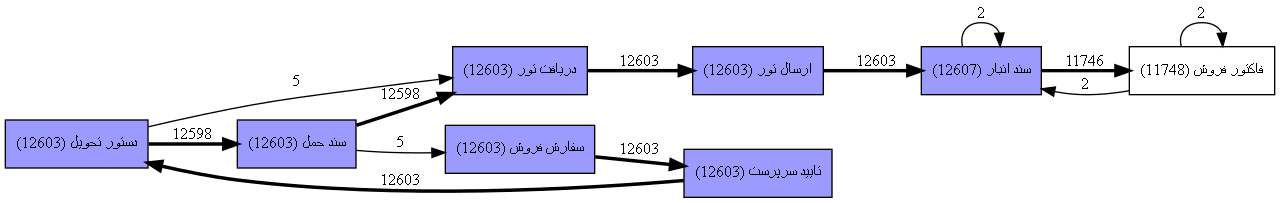

In [13]:
dfg = dfg_discovery.apply(event_log)


from pm4py.visualization.dfg import visualizer as dfg_visualization

gviz = dfg_visualization.apply(dfg, log=event_log, variant=dfg_visualization.Variants.FREQUENCY)

# Save
pn_visualizer.save(gviz, SRC_DIR / 'Images' / 'ProcessDiscovery' / 'Direct Flow Graph.png')

dfg_visualization.view(gviz)

<div style="direction:rtl;line-height:300%;">
	<font face="XB Nazanin" size=4 color=blue>
		<div align=right>
			<font face="B Nazanin" size=5>
				<p></p>
				<p></p>
               سه variant در نقشه فرآیند بالا قابل مشاهده است.

In [19]:
from pm4py.algo.filtering.log.variants import variants_filter
variants = variants_filter.get_variants(event_log)
  
print(f"We have:{len(variants)} variants in our event log")


We have:3 variants in our event log


<div style="direction:rtl;line-height:300%;">
	<font face="Calibri" size=4 color=blue>
		<div align=left>
			<font face="Calibri" size=5>
				<p></p>
				<p></p>
               Heuristics Miner

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

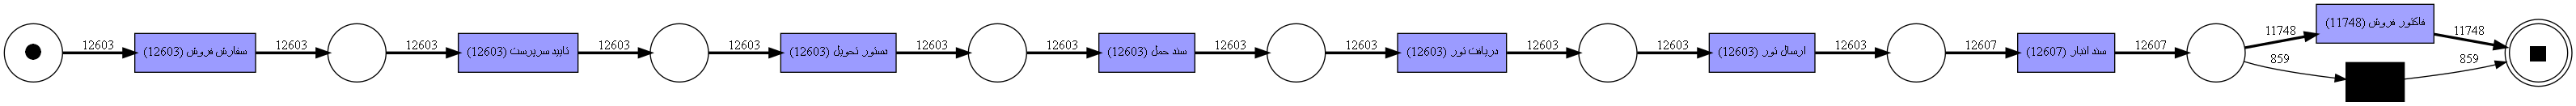

In [33]:
# Parameters
parameters = heuristics_miner.Variants.CLASSIC.value.Parameters

# Miner
petri_net, initial_marking, final_marking = heuristics_miner.apply(
    event_log,
    parameters={
        parameters.DEPENDENCY_THRESH: 0.5, 
        parameters.AND_MEASURE_THRESH: 0.65,
        parameters.LOOP_LENGTH_TWO_THRESH: 0.5
    }
)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking,
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=event_log)

# Save
pn_visualizer.save(gviz, SRC_DIR / 'Images' / 'ProcessDiscovery' / 'heuristic_miner_3.png')

# View
pn_visualizer.view(gviz)

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

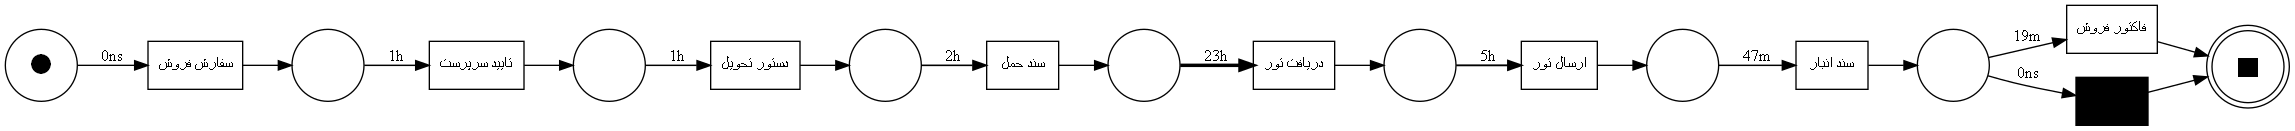

In [36]:
# Parameters
parameters = heuristics_miner.Variants.CLASSIC.value.Parameters

# Miner
petri_net, initial_marking, final_marking = heuristics_miner.apply(
    event_log,
    parameters={
        parameters.DEPENDENCY_THRESH: 0.1, 
        parameters.AND_MEASURE_THRESH: 0.1,
        parameters.LOOP_LENGTH_TWO_THRESH: 1
    }
)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking,
                           variant=pn_visualizer.Variants.PERFORMANCE, 
                           log=event_log)

# Save
pn_visualizer.save(gviz, SRC_DIR / 'Images' / 'ProcessDiscovery' / 'heuristic_miner_5.png')

# View
pn_visualizer.view(gviz)

In [37]:
ad_df

,event_from,event_to,mean_duration,total_duration,std_duration,count
0,ارسال تور,سند انبار,0.776077,9780.896389,0.630169,12603
1,تاييد سرپرست,دستور تحويل,1.171383,14762.936389,3.642978,12603
2,دريافت تور,ارسال تور,5.796661,73055.320278,4.722683,12603
3,دستور تحويل,دريافت تور,2.010444,10.052222,1.495084,5
4,دستور تحويل,سند حمل,2.752147,34671.554167,3.821181,12598
5,سفارش فروش,تاييد سرپرست,1.525684,19228.193889,3.052040,12603
6,سند انبار,سند انبار,1.996250,3.992500,0.071693,2
7,سند انبار,فاکتور فروش,0.319522,3753.103889,5.789051,11746
8,سند حمل,دريافت تور,23.510841,296189.579167,18.976553,12598
9,سند حمل,سفارش فروش,17.974056,89.870278,0.983692,5


<div style="direction:rtl;line-height:300%;">
	<font face="XB Nazanin" size=4 color=blue>
		<div align=right >
			<font face="B Nazanin" size=5>
				<p></p>
				<p></p>
                با توجه به دیتافریم بالا و همچنین نقشه فرآیند بالای آن که performance در آن نمایش داده شده، مجموع زمان از فعالیت سند حمل به دریافت تور 296189.579167 ساعت است و به طور میانگین 23.5 ساعت صرف این فعالیت شده است.  
<br>همچنین مجموع زمان فعالیت از دریافت تور به فعالیت ارسال تور 73055.320278 است و به طور میانگین 5.8 ساعت صرف این فعالیت شده است.
<br>به‌منظور کاهش زمان فرآیند، انجام فعالیت‌های سند حمل و دریافت تور می‌بایست بهینه‌سازی شود. 


<div style="direction:rtl;line-height:300%;">
	<font face="Calibri" size=4 color=blue>
		<div align=left>
			<font face="Calibri" size=5>
				<p></p>
				<p></p>
                Inductive Miner

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

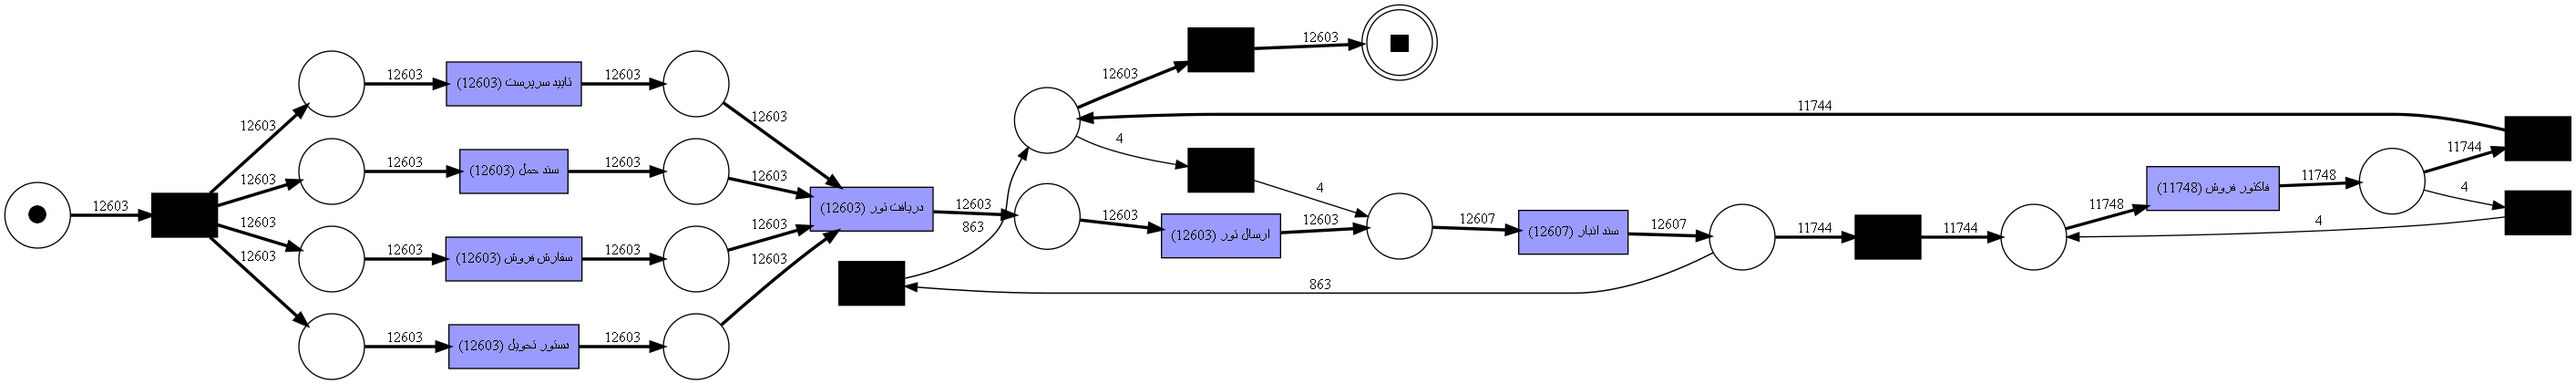

In [14]:
# Miner
petri_net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(event_log)

# GraphViz

gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking,
                           variant = pn_visualizer.Variants.FREQUENCY, 
                           log = event_log)

# Save
pn_visualizer.save(gviz, SRC_DIR / 'Images' / 'ProcessDiscovery' / 'IM_frequency_petri.png')

# View
pn_visualizer.view(gviz)

In [15]:
def heuristics_process_model(dependency_threshold, and_threshold, loop_two_threshold):
    # Parameters
    parameters = heuristics_miner.Variants.CLASSIC.value.Parameters

    # Miner
    petri_net, initial_marking, final_marking = heuristics_miner.apply(
        event_log,
        variant=heuristics_miner.Variants.CLASSIC, 
        parameters={
            parameters.DEPENDENCY_THRESH: dependency_threshold, 
            parameters.AND_MEASURE_THRESH: and_threshold,
            parameters.LOOP_LENGTH_TWO_THRESH: loop_two_threshold
        }
    )

    # GraphViz
    gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking,
                               variant=pn_visualizer.Variants.FREQUENCY, 
                               log=event_log)
    
    # Save
    pn_visualizer.save(gviz, SRC_DIR / 'Images' / 'ProcessDiscovery' / 'heuristic_miner_4.png')
    
    # View
    vis_utils.view_image_in_jupyter(SRC_DIR / 'Images' / 'ProcessDiscovery' / 'heuristic_miner_4.png')



interact(
    heuristics_process_model,

    dependency_threshold = widgets.FloatSlider(
        value=0.5, min=0, max=1, step=0.01, description='Dependency:', 
        disabled=False, continuous_update=False, orientation='horizontal', 
        readout=True, readout_format='.2f'
    ),

    and_threshold = widgets.FloatSlider(
        value=0.65, min=0, max=1, step=0.01, description='And:', 
        disabled=False, continuous_update=False, orientation='horizontal', 
        readout=True, readout_format='.2f'
    ),

    loop_two_threshold = widgets.FloatSlider(
        value=0.5, min=0, max=1, step=0.01, description='Loop Two:', 
        disabled=False, continuous_update=False, orientation='horizontal', 
        readout=True, readout_format='.2f'
    ),
)


interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='Dependency:', max=1.0, step…

<function __main__.heuristics_process_model(dependency_threshold, and_threshold, loop_two_threshold)>

In [ ]:
os.environ["PATH"] += os.pathsep + 'C:/ProgramData/anaconda3/Lib/site-packages/graphviz/'